Author: Stephan, stephan@bayesimpact.org

# Holland Codes

https://en.wikipedia.org/wiki/Holland_Codes

There is a theory that associates 6 basic characteristics with people. These characteristics can be used to help people find jobs they like. The theory still seems to be widely used for career counceling. 

![RIASEC hexagon](https://41.media.tumblr.com/175b64f9478b747fd44a0f29e747a176/tumblr_nbem00Cjxd1qjdds2o1_500.jpg)

Usually people are gradually associated with multiple characteristics, a person does ususally not fit neatly into one of the boxes. However when people are associated with multiple characteristics, these tend to be neighboring on the above hexagon. It is less common that someone is associated with two characteristics on opposite ends of the hexagaon. These are even called [inconsistent personality patterns](https://www.careerkey.org/choose-a-career/inconsistent-Holland-personality-types-advice.html#.VjOp7hCrTMV).

In the ROME dataset each job and each activity has a major and a minor Holland Code assigned. We want to use these to help people find a job in a field they like, and maybe did not think of previously.

In [1]:
%matplotlib inline

from __future__ import division
import glob
import json
import itertools as it

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xmltodict
import numpy as np

from bob_emploi.lib import read_data

WEB_APP_PATH = '/Users/dedan/projects/les-jobs/'

In [2]:
def riasec_dist(first, second):
    '''compute the distance between two characteristics on the hexagon'''
    if pd.isnull(first) or pd.isnull(second):
        return np.nan
    riasec = "RIASEC"
    a = riasec.find(first.upper())
    b = riasec.find(second.upper())
    assert a >= 0 and b >= 0
    return min( (a-b)%6, (b-a)%6)

# to call it on a dataframe row
riasec_dist_row = lambda row: riasec_dist(row.riasec_majeur, row.riasec_mineur)

### Job fiches

First load all the job_groups (fiche metier) from the XML files

In [3]:
fiche_dicts = read_data.load_fiches_from_xml('../data/ficheMetierXml')

In [4]:
fiches = pd.DataFrame(fiche['bloc_code_rome'] for fiche in fiche_dicts)
fiches['riasec_mineur'] = fiches.riasec_mineur.str.upper()
fiches['combined'] = fiches.riasec_majeur + fiches.riasec_mineur
fiches['riasec_dist'] = fiches.apply(riasec_dist_row, axis=1)

Visualize the distributions of Holland Codes for job fiches

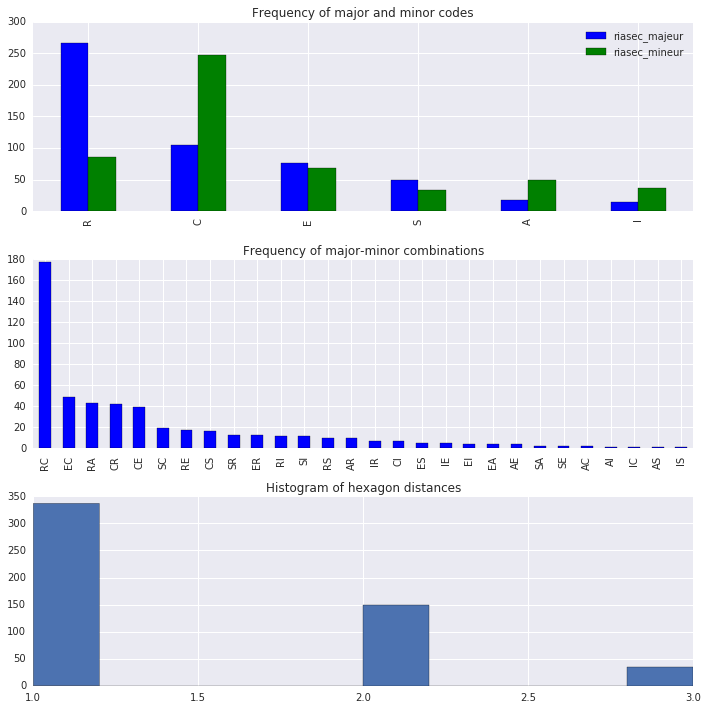

In [5]:
def visualize_codes(thing):
    '''Visualize the distribution of Holland codes
    major codes, minor codes, the combinations of both 
    and distances between
    '''
    riasec_counts = thing.riasec_majeur.value_counts().to_frame()
    riasec_counts['riasec_mineur'] = thing.riasec_mineur.value_counts()

    fig, ax = plt.subplots(3, figsize=(10, 10))
    riasec_counts.plot(kind='bar', ax=ax[0])
    thing.combined.value_counts().plot(kind='bar', ax=ax[1])
    thing.riasec_dist.hist(ax=ax[2])
    ax[0].set_title('Frequency of major and minor codes')
    ax[1].set_title('Frequency of major-minor combinations')
    ax[2].set_title('Histogram of hexagon distances')

    fig.tight_layout()
    
visualize_codes(fiches)

### Holland Codes of activities associated with jobs

In [6]:
def extract(fiche):
    '''extract the base activities associated with a job fiche'''
    base_acts = fiche['bloc_activites_de_base']['activites_de_base']['item_ab'] 
    rome = {'rome_' + k: v for k, v in fiche['bloc_code_rome'].items()}
    return [dict(rome, **ba) for ba in base_acts]

fiche_acts = pd.DataFrame(sum(map(extract, fiche_dicts), []))
fiche_acts['riasec_mineur'] = fiche_acts.riasec_mineur.str.upper()
fiche_acts['rome_riasec_mineur'] = fiche_acts.riasec_mineur.str.upper()

In [7]:
%qtconsole

How often are the Holland Codes of the activity the same as for the job?

In [8]:
combinations = it.product(['majeur', 'mineur'], ['majeur', 'mineur'])
for job, act in combinations:
    job_key = 'rome_riasec_' + job
    act_key = 'riasec_' + act
    match_count = (fiche_acts[job_key] == fiche_acts[act_key]).sum()
    fmt_str = "{} job fiche matches {} activity fiche in {:.2f}%"
    print(fmt_str.format(job, act, match_count / len(fiche_acts) * 100))

majeur job fiche matches majeur activity fiche in 56.02%
majeur job fiche matches mineur activity fiche in 17.15%
mineur job fiche matches majeur activity fiche in 0.00%
mineur job fiche matches mineur activity fiche in 50.40%


Dump the job fiches plus Holland Codes into a `.json` for usage in the web app.

In [9]:
to_save = fiches.set_index('code_rome')
to_save['job_activities'] = fiche_acts.groupby('rome_code_rome').code_ogr.apply(list)
to_save.reset_index().to_json(WEB_APP_PATH + 'src/data/jobs.json', orient='records')

### Activities

Let's look at the Holland Codes associated with activities.

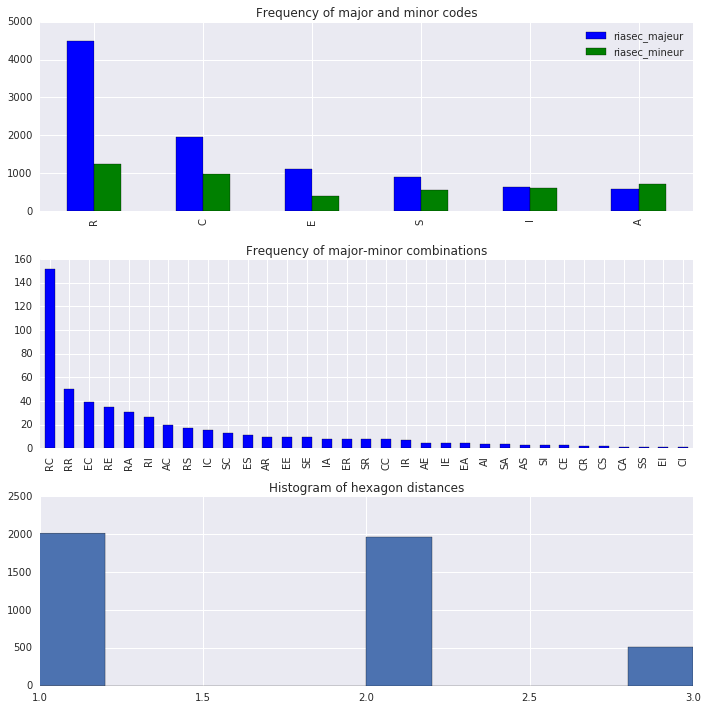

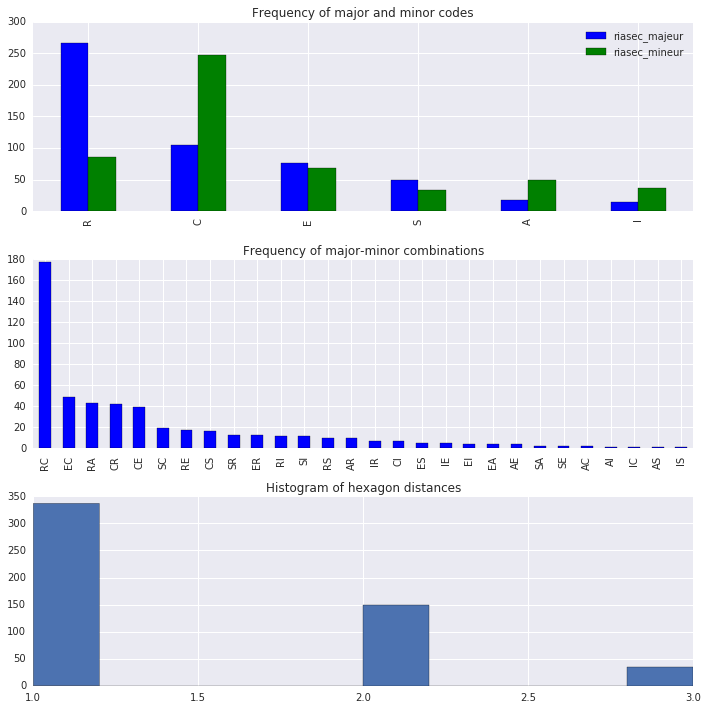

In [10]:
activities = pd.read_csv('../data/rome/csv/unix_referentiel_activite_v329_utf8.csv')
act_riasec = pd.read_csv('../data/rome/csv/unix_referentiel_activite_riasec_v329_utf8.csv')
acts = pd.merge(activities, act_riasec, on='code_ogr')

acts['riasec_mineur'] = acts.riasec_mineur.str.upper()
acts['combined'] = acts.riasec_majeur + fiches.riasec_mineur
acts['riasec_dist'] = acts.apply(riasec_dist_row, axis=1)

base_acts = acts[acts.libelle_type_activite == 'ACTIVITE DE BASE']

visualize_codes(acts)
visualize_codes(fiches) #for comparison

Create json file for the activities to be used in web app

In [11]:
base_acts.to_json(WEB_APP_PATH + 'src/data/activities.json', orient='records')

### Agreement between job Holland code and activity Holland codes

Eeach job has a Holland code. Additionally each job has many activities associated, which in turn also have Holland codes associated. I was wondering how they came up with this classification, did they assign the Holland code of a job based on the prevailing Holland codes of its activities? I asked Matthieu, but he could not help me with that. Let's look at the data

In [12]:
cols = ['rome_code_rome', 'rome_riasec_majeur']
bla = fiche_acts.groupby(cols).riasec_majeur.value_counts().reset_index()
bla.rename(columns={0:'count'}, inplace=True)
res = bla.groupby('rome_code_rome').max().reset_index()

print((res.rome_riasec_majeur == res.riasec_majeur).sum() / len(res))

0.591337099812


For about 60% of the the job_groups, the major RIASEC code corresponds to the RIASEC code that is most common for its activities. In the current version of the webapp (Nov 9, 2015) I compute for each user a RIASEC profile depending on which activities she likes. I match the most common RIASEC code of this profile to the major RIASEC code of the job group. 

The result that only 60% of the job_group's RIASEC codes are determined by their activities makes me question this method. It is probably better to compute a RIASEC profile for each job_group based on its activities. I can then compute the cosine similarity between a user's profile and that of a job. This method will also allow for a gradual ranking of job fit instead of a binary selection (major code of job matches most common code of user profile)

### Holland Code descriptions

I extracted Holland Code descriptions from a website (HTML). Convert it to JSON for usage in the webapp.

In [13]:
with open('../data/riasec_types.xml') as f:
    bla = xmltodict.parse(f.read())

with open(WEB_APP_PATH + 'src/data/holland_codes.json', 'w') as outfile:
    json.dump(bla['div']['ul'], outfile)